In [1]:
# Clone the SleepQA repo
!git clone https://github.com/IvaBojic/SleepQA.git
%cd SleepQA

# Install key dependencies
!pip install transformers faiss-cpu datasets scikit-learn pandas tqdm


Cloning into 'SleepQA'...
remote: Enumerating objects: 400, done.
remote: Counting objects: 100% (87/87), done.
remote: Compressing objects: 100% (66/66), done.
remote: Total 400 (delta 46), reused 43 (delta 19), pack-reused 313 (from 1)
Receiving objects: 100% (400/400), 31.13 MiB | 13.59 MiB/s, done.
Resolving deltas: 100% (176/176), done.
Updating files: 100% (134/134), done.
Filtering content: 100% (3/3), 1.21 GiB | 48.69 MiB/s, done.
/content/SleepQA
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.3/31.3 MB 64.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.4/491.4 kB 29.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 16.3 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing install

In [2]:
import os
import pandas as pd
from sentence_transformers import SentenceTransformer, InputExample, losses
from torch.utils.data import DataLoader
import faiss
import numpy as np
import time
import torch
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt  # Add at the top if not already

# 1. Load data
corpus = pd.read_csv("data/training/sleep-corpus.tsv", sep="\t", header=None)
corpus.columns = ['index', 'passage', 'title']
test_qs = pd.read_csv("data/training/sleep-test.csv", sep="\t", header=None)
test_qs.columns = ['question', 'answer']

# 2. Setup models
models = {
    "SciBERT": "allenai/scibert_scivocab_uncased"
}

# 3. Prepare training examples
train_examples = [
    InputExample(texts=[row["question"], row["answer"]], label=1.0)
    for _, row in test_qs.iterrows()
]

# 4. Set hyperparameters
EPOCHS = 30
BATCH_SIZE = 16
LEARNING_RATE = 2e-5  # (cannot be directly set in SentenceTransformer.fit)

# Track compute
total_gpu_time = 0
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Hardware: Using {'GPU' if device == 'cuda' else 'CPU'}")

# 5. Define FAISS search
def query_faiss(question, model, top_k=3):
    q_emb = model.encode([question], convert_to_numpy=True)
    D, I = index.search(q_emb, top_k)
    return [corpus.iloc[i]["passage"] for i in I[0]], D[0]

# 6. Define evaluation metrics
def evaluate_model(model, test_df, ks=[1]):
    results = {}

    for k in ks:
        recall_at_k = []
        exact_match = []
        f1_scores = []

        for _, row in test_df.iterrows():
            question = row["question"]
            true_answer = row["answer"]

            retrieved_passages, _ = query_faiss(question, model, top_k=k)

            # Recall@k: if true answer appears in any retrieved passage
            match_found = any(true_answer.strip().lower() in passage.lower() for passage in retrieved_passages)
            recall_at_k.append(1 if match_found else 0)

            # Exact Match
            em = any(true_answer.strip().lower() == passage.strip().lower() for passage in retrieved_passages)
            exact_match.append(1 if em else 0)

            # F1 score (token level) with best candidate
            best_f1 = 0
            for passage in retrieved_passages:
                true_tokens = set(true_answer.lower().split())
                pred_tokens = set(passage.lower().split())
                common = true_tokens & pred_tokens
                if not common:
                    continue
                precision = len(common) / len(pred_tokens)
                recall = len(common) / len(true_tokens)
                f1 = 2 * precision * recall / (precision + recall)
                best_f1 = max(best_f1, f1)
            f1_scores.append(best_f1)

        # Store results for each k
        results[k] = {
            "Recall@k": np.mean(recall_at_k),
            "Exact Match": np.mean(exact_match),
            "F1 Score": np.mean(f1_scores)
        }

    return results

# 7. Train and evaluate each model
for model_name, model_id in models.items():
    print(f"\n### Training Model: {model_name} ###")

    model = SentenceTransformer(model_id, device=device)
    train_dataloader = DataLoader(train_examples, shuffle=True, batch_size=BATCH_SIZE)
    train_loss = losses.CosineSimilarityLoss(model)

    start_time = time.time()
    model.fit(
        train_objectives=[(train_dataloader, train_loss)],
        epochs=EPOCHS,
        warmup_steps=10,
        show_progress_bar=True
    )
    end_time = time.time()

    epoch_time = (end_time - start_time) / EPOCHS
    total_gpu_time += (end_time - start_time)

    print(f"Training time: {end_time - start_time:.2f}s total | {epoch_time:.2f}s per epoch")

    # Compute embeddings
    corpus_embeddings = model.encode(corpus["passage"].tolist(), show_progress_bar=True, convert_to_numpy=True)
    index = faiss.IndexFlatL2(corpus_embeddings.shape[1])
    index.add(corpus_embeddings)

    # Show top-3 results for first question
    sample_question = test_qs.iloc[0]["question"]
    results, distances = query_faiss(sample_question, model, top_k=3)

    print("\nTop-3 Similar Passages:")
    for i, (text, dist) in enumerate(zip(results, distances)):
        print(f"Rank {i+1}: {text[:100]}... (Distance: {dist:.4f})")

    # Save model
    os.makedirs("saved_models", exist_ok=True)
    model_save_path = f"saved_models/{model_name.replace(' ', '_')}"
    model.save(model_save_path)
    print(f"Model saved to: {model_save_path}")

    # Evaluate model

    # Initialize metrics dictionary
    if 'all_metrics' not in locals():
        all_metrics = {}

    # Evaluate model
    metrics = evaluate_model(model, test_qs, ks=[1,20,40,60,80,100])
    all_metrics[model_name] = metrics

    print(f"\nEvaluation Metrics for {model_name}:")
    for k, metrics_at_k in metrics.items():
        print(f"- k={k}:")
        for metric_name, value in metrics_at_k.items():
            print(f"    {metric_name}: {value:.4f}")  # Format the value to 4 decimal places


# 8. Final report
print("\n=================== Training Summary ===================")
print(f"Hyperparameters Used:")
print(f"- Learning Rate: {LEARNING_RATE} (default for transformers)")
print(f"- Batch Size: {BATCH_SIZE}")
print(f"- Epochs: {EPOCHS}")
print(f"\nComputational Requirements:")
print(f"- Hardware: {'GPU' if device == 'cuda' else 'CPU'}")
print(f"- Models Trained: {len(models)}")
print(f"- Average Epoch Time (last model): {epoch_time:.2f}s")
print(f"- Total GPU Time: {total_gpu_time/3600:.2f} GPU hours")
print(f"\nTraining Details:")
print(f"- Loss Function: CosineSimilarityLoss")


Hardware: Using CPU

### Training Model: SciBERT ###


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/442M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/442M [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/228k [00:00<?, ?B/s]

Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: fairiesrock7 (fairiesrock7-zero2one-uiuc) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Step,Training Loss
500,0.001100


Training time: 9521.38s total | 317.38s per epoch


Batches:   0%|          | 0/219 [00:00<?, ?it/s]


Top-3 Similar Passages:
Rank 1: for example, solo sailors switch to a polyphasic sleep schedule when preparing for a race. it should... (Distance: 4.5905)
Rank 2: sleep deprivation can cause chronic health problems down the line, so it is important to monitor any... (Distance: 5.0928)
Rank 3: while the current social assumption is that couples sleep together, sleeping apart may work better f... (Distance: 5.1848)
Model saved to: saved_models/SciBERT

Evaluation Metrics for SciBERT:
- k=1:
    Recall@k: 0.0000
    Exact Match: 0.0000
    F1 Score: 0.0454
- k=20:
    Recall@k: 0.0000
    Exact Match: 0.0000
    F1 Score: 0.0804
- k=40:
    Recall@k: 0.0000
    Exact Match: 0.0000
    F1 Score: 0.0855
- k=60:
    Recall@k: 0.0000
    Exact Match: 0.0000
    F1 Score: 0.0890
- k=80:
    Recall@k: 0.0000
    Exact Match: 0.0000
    F1 Score: 0.0913
- k=100:
    Recall@k: 0.0000
    Exact Match: 0.0000
    F1 Score: 0.0930

=================== Training Summary ===================
Hyperparam

In [4]:
# Evaluate model
#from sentence_transformers import SentenceTransformer

# Load the saved model from the specified path
#odel = SentenceTransformer("saved_models/PubMedBERT")

# Now you can use the model for encoding, querying, etc.

#metrics = evaluate_model(model, test_qs, ks=[1,20,40,60,80,100])
#all_metrics[model_name] = metrics

#print(f"\nEvaluation Metrics for {model_name}:")
#print(f"\nEvaluation Metrics for {model_name}:")
#for k, metrics_at_k in metrics.items():
    #print(f"- k={k}:")
    #for metric_name, value in metrics_at_k.items():
        #print(f"    {metric_name}: {value:.4f}")  # Format the value to 4 decimal places
# 8. Final report
#print("\n=================== Training Summary ===================")
#print(f"Hyperparameters Used:")
#print(f"- Learning Rate: {LEARNING_RATE} (default for transformers)")
#print(f"- Batch Size: {BATCH_SIZE}")
#print(f"- Epochs: {EPOCHS}")
#print(f"\nComputational Requirements:")
#print(f"- Hardware: {'GPU' if device == 'cuda' else 'CPU'}")
#print(f"- Models Trained: {len(models)}")
#print(f"- Average Epoch Time (last model): {epoch_time:.2f}s")
#print(f"- Total GPU Time: {total_gpu_time/3600:.2f} GPU hours")
#print(f"\nTraining Details:")
#print(f"- Loss Function: CosineSimilarityLoss")



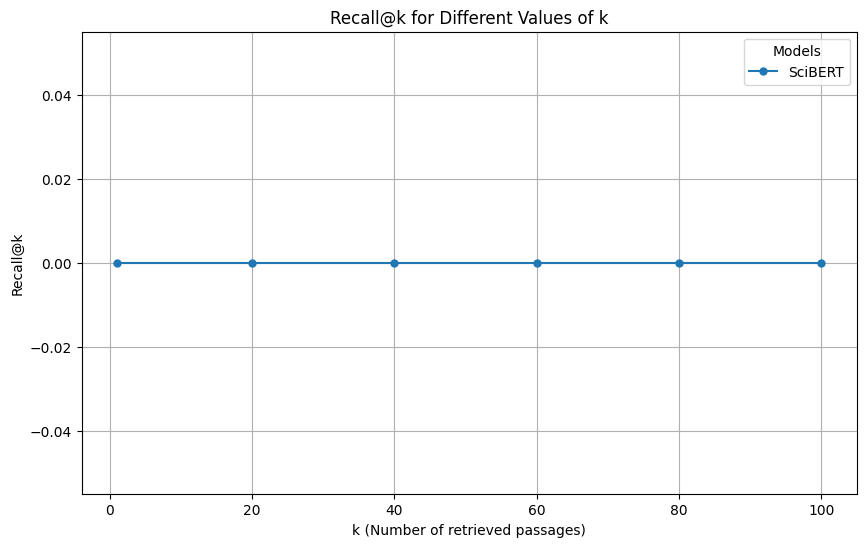

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming all_metrics contains the results in the following format:
# all_metrics = {
#     'model_name_1': {
#         1: {"Recall@k": 0.85, "Exact Match": 0.75, "F1 Score": 0.80},
#         20: {"Recall@k": 0.90, "Exact Match": 0.80, "F1 Score": 0.83},
#         40: {"Recall@k": 0.91, "Exact Match": 0.81, "F1 Score": 0.84},
#         ...
#     },
#     ...
# }

# Extracting Recall@k for each model
def plot_recall_at_k(all_metrics):
    plt.figure(figsize=(10, 6))

    for model_name, metrics in all_metrics.items():
        ks = sorted(metrics.keys())  # Sorted k values
        recall_at_k = [metrics[k]["Recall@k"] for k in ks]

        # Plotting Recall@k vs k for the model
        plt.plot(ks, recall_at_k, label=model_name, marker='o', linestyle='-', markersize=5)

    # Customizing the plot
    plt.xlabel("k (Number of retrieved passages)")
    plt.ylabel("Recall@k")
    plt.title("Recall@k for Different Values of k")
    plt.legend(title="Models")
    plt.grid(True)
    plt.show()

# Example usage:
plot_recall_at_k(all_metrics)
